<a href="https://colab.research.google.com/github/shakurov-family/Copy-of-YOLACT-Eval.ipynb/blob/main/Copy_of_YOLACT_Eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLACT Google Colab Notebook
Inference on images and video with [YOLACT](https://github.com/dbolya/yolact).

## Google Colab
This notebook is set up to work inside Google Colab, which is a free, Linux-based Jupyter Notebook environment hosted in the cloud.

If you try it outside of Google Colab I'm not sure if it will work. I originally had problems running locally on my Windows machine, which is why I switched to this.

### Runtime Setup
- Go to Runtime > Change Runtime Type
- Choose GPU (TPU won't work)

## YOLACT
YOLACT is a state of the art, real-time, single shot object segmentation algorithm detailed in these papers:  
- [YOLACT: Real-time Instance Segmentation](https://arxiv.org/abs/1904.02689)
- [YOLACT++: Better Real-time Instance Segmentation](https://arxiv.org/abs/1912.06218)

**Big thanks to the authors: Daniel Bolya, Chong Zhou, Fanyi Xiao, Yong Jae Lee!**

## Immersive Limit
This notebook was created by Adam Kelly, instructor/creator of [immersivelimit.com](https://www.immersivelimit.com).
- Subscribe for lots more awesome AI and 3D content on the [YouTube channel](https://www.youtube.com/c/immersivelimit)
- Check out https://www.immersivelimit.com/connect for more ways to follow/connect 😀

# Initial Setup
First, we install some Python libraries. Google Colab probably has these requirements already, but better to include them than to break later.

In [ ]:
# Cython needs to be installed before pycocotools
!pip install cython
!pip install opencv-python pillow pycocotools matplotlib

In [ ]:
# Downgrade torch to accommodate DCNv2
!pip install torchvision==0.5.0
!pip install torch==1.4.0


     |████████████████████████████████| 4.0 MB 12.0 MB/s 
     |████████████████████████████████| 753.4 MB 7.4 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.


## Clone YOLACT from GitHub
Let's get that github repo! If anything in this notebook breaks, check the repo in case they've made updates.

In [ ]:
# Make sure we're in the top folder
%cd /content

# Clone the repo
!git clone https://github.com/shakurov-family/yolact  

/content
Cloning into 'yolact'...
remote: Enumerating objects: 2936, done.
remote: Total 2936 (delta 0), reused 0 (delta 0), pack-reused 2936
Receiving objects: 100% (2936/2936), 21.20 MiB | 20.60 MiB/s, done.
Resolving deltas: 100% (2002/2002), done.


## DCNv2
The DCNv2 external library is needed for this to work, so we'll build it now.

**IF YOU GET CUDA ERRORS** You need to change the Runtime of this notebook to "GPU" as mentioned at the top of the notebook.

In [ ]:
# Change to the right directory
%cd /content/yolact/external/DCNv2

# Build DCNv2
!python setup.py build develop

/content/yolact/external/DCNv2
running build
running build_ext
building '_ext' extension
creating build
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/content
creating build/temp.linux-x86_64-3.7/content/yolact
creating build/temp.linux-x86_64-3.7/content/yolact/external
creating build/temp.linux-x86_64-3.7/content/yolact/external/DCNv2
creating build/temp.linux-x86_64-3.7/content/yolact/external/DCNv2/src
creating build/temp.linux-x86_64-3.7/content/yolact/external/DCNv2/src/cpu
creating build/temp.linux-x86_64-3.7/content/yolact/external/DCNv2/src/cuda
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-dIfpci/python3.7-3.7.13=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-dIfpci/python3.7-3.7.13=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -DWITH_CUDA -I/content/yolact/exte

## Pretrained Weights
In order to run inference, we'll need some pre-trained weights. The creator of the GitHub repo shared them on Google Drive. We're going to use a [helpful tool](https://github.com/chentinghao/download_google_drive) made by [chentinghao](https://github.com/chentinghao) to easily access the Drive file from Colab.

If this stops working, it's probably because the weights moved to a different location. Check the YOLACT github repo to see where they went.

In [ ]:
# Make sure we're in the top folder
%cd /content

# Clone the repo
!git clone https://github.com/shakurov-family/download_google_drive.git 

# Create a new directory for the pre-trained weights
!mkdir -p /content/yolact/weights

# Download the file
!python ./download_google_drive/download_gdrive.py 1ZPu1YR2UzGHQD0o1rEqy-j5bmEm3lbyP ./yolact/weights/yolact_plus_resnet50_54_800000.pth

/content
Cloning into 'download_google_drive'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 19 (delta 0), reused 0 (delta 0), pack-reused 16
Unpacking objects: 100% (19/19), done.
129MB [00:00, 152MB/s]


# Get Test Images
We'll download a few test images from the [COCO dataset](http://cocodataset.org/#explore). Feel free to try out your own images as well, but know that there are only 80 categories and they're not intended to cover everything, so if you upload a picture of a snake, a mouse, and a cat, only the cat will be detected.

In [9]:
# !rm /content/test_images -r

# Make a new directory for the test images
!mkdir /content/test_images

# Move to the new directory
%cd /content/test_images

# Make a list of URLs from the COCO dataset
get_imgs = [
            'https://theecology.xyz/wp-content/uploads/2019/09/post_5d76608fc5a61.jpeg'
            # 'http://farm8.staticflickr.com/7200/6946559805_7edf757660_z.jpg',
            # 'http://farm3.staticflickr.com/2835/9520716824_51220b13d0_z.jpg',
            # 'http://farm3.staticflickr.com/2817/10105052924_0c8d79e62c_z.jpg',
            # 'https://farm3.staticflickr.com/2637/3679968895_37a79e55b3_z.jpg',
            # 'https://farm8.staticflickr.com/7137/7705349298_6bea29cf1c_z.jpg',
            # 'http://farm5.staticflickr.com/4105/4981945644_3f162314ed_z.jpg',
            # 'http://farm1.staticflickr.com/40/101757885_a8fc40e273_z.jpg',
            # 'http://farm3.staticflickr.com/2654/3897535041_fa8dd5570b_z.jpg'
            ]

# Download all the images
for img_url in get_imgs:
  !wget {img_url} -nc

# List the contents of the folder. Should have images.
!pwd
!ls

/content/test_images
--2022-03-25 19:14:49--  https://theecology.xyz/wp-content/uploads/2019/09/post_5d76608fc5a61.jpeg
Resolving theecology.xyz (theecology.xyz)... 104.21.85.250, 172.67.212.254, 2606:4700:3037::ac43:d4fe, ...
Connecting to theecology.xyz (theecology.xyz)|104.21.85.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74667 (73K) [image/jpeg]
Saving to: ‘post_5d76608fc5a61.jpeg’

post_5d76608fc5a61. 100%[===================>]  72.92K  --.-KB/s    in 0.005s  

2022-03-25 19:14:49 (14.0 MB/s) - ‘post_5d76608fc5a61.jpeg’ saved [74667/74667]

/content/test_images
post_5d76608fc5a61.jpeg


# Run Inference on Images
Let's run inference. We do that with eval.py

In [10]:
# Move up to the top level directory
%cd /content

# Delete any previous output_images folder (in case we're running this more than once)
!rm /content/output_images -r

# Create a new directory for output images
!mkdir -p /content/output_images

# Run inference using our pre-trained weights on all images in the directory
!python ./yolact/eval.py --trained_model=./yolact/weights/yolact_plus_resnet50_54_800000.pth --config=yolact_plus_resnet50_config --score_threshold=0.15 --top_k=15 --images=test_images:output_images

/content
Loading model... Done.

test_images/post_5d76608fc5a61.jpeg -> output_images/post_5d76608fc5a61.png
Done.


## Display Output Images
The last step saved output images, so we'll display those now.

output_images/post_5d76608fc5a61.png


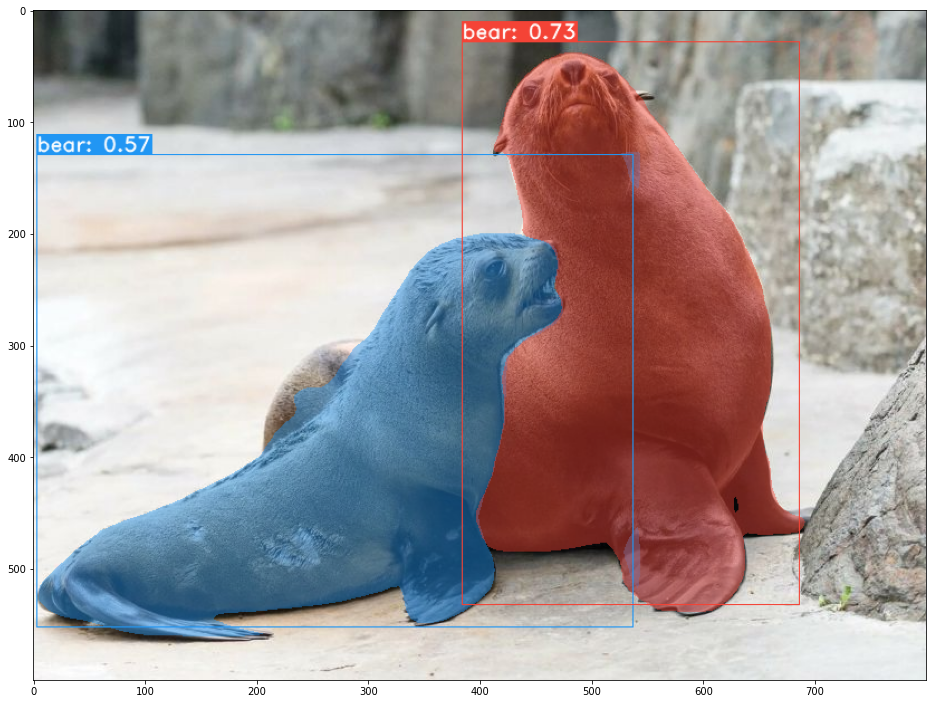

In [11]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path

output_images = Path('output_images')

def show_image(img_path):
  img = cv2.imread(img_path)
  img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.figure(figsize=(16,16))
  plt.imshow(img_cvt)
  plt.show()

# Iterate through all of the output images and display them
for img_path in output_images.iterdir():
  print(img_path)
  show_image(str(img_path))

# Run Inference on Video
I can't figure out how to get Google Colab to show the output video in the notebook, so I've uploaded the video to YouTube. The mask quality is incredible. There are some false positives because it thinks the rocks are sheep, but we'll give it a pass because it's never been told what a rock is before (COCO dataset doesn't contain rocks) and the rocks do look a bit sheepish.


In [ ]:
from IPython.display import HTML
HTML('<iframe width="1280" height="720" src="https://www.youtube.com/embed/bQgtmbzN7jg" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

Подключаем диск Google Drive

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now we run inference.
Указываем имя файла и папку на Google Drive.

In [72]:
# file_name = "DSCF6744.AVI"
# drive_folder = "2009-10,11,12 Разное и Новый год 2010"
file_name = "DSCF6744.mp4"
drive_folder = "Временные"


file_path = "\"/content/drive/MyDrive/" + str(drive_folder) + "/" + str(file_name) + "\""
output_path = "/content/output_videos/" + str(file_name)

!ls -l {file_path}

!echo "Processing " {file_path} " ..." to {output_path}
%cd /content
!mkdir -p /content/output_videos
!python ./yolact/eval.py --trained_model=./yolact/weights/yolact_plus_resnet50_54_800000.pth --score_threshold=0.15 --top_k=15 --video_multiframe=4 --video={file_path}:{output_path}

-rw------- 1 root root 7090115 Mar 25 20:59 /content/drive/MyDrive/Временные/DSCF6744.mp4
Processing  /content/drive/MyDrive/Временные/DSCF6744.mp4  ... to /content/output_videos/DSCF6744.mp4
/content
Config not specified. Parsed yolact_plus_resnet50_config from the file name.

Loading model... Done.
Initializing model... Done.

Processing Frames  ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░      5 /   1410 ( 0.35%)     4.72 fps        Traceback (most recent call last):
  File "./yolact/eval.py", line 1105, in <module>
    evaluate(net, dataset)
  File "./yolact/eval.py", line 890, in evaluate
    evalvideo(net, inp, out)
  File "./yolact/eval.py", line 832, in evalvideo
    frame_buffer.put(frame['value'].get())
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 657, in get
    raise self._value
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "./yolact/eval.py", line 712, in prep_frame
    return prep_display(preds, fra

## Download the output file
In this part, we'll mount your Google Drive and you can copy the file somewhere over there. I tried using the google.colab.files library to download the file, but it doesn't seem to like big video files.

- You will need to authorize your Drive to connect, then it basically just links your drive as if it's a folder on this cloud computer.
- **Be careful** because if you start deleting/modifying files in this folder, you will modify your personal Google Drive.


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [66]:
!mkdir -p /content/drive/My\ Drive/YOLACT_output
%cd /content/drive/My\ Drive/YOLACT_output
!ls

/content/drive/My Drive/YOLACT_output
'Colab Notebooks'   rare_animals_of_Siberia.mp4


In [26]:
!echo {output_path}
!cp {output_path} /content/drive/My\ Drive/YOLACT_output/{file_name}

/content/output_videos/rare_animals_of_Siberia.mp4


## Find the Video on Google Drive
Now you should be able to view the file on your Google Drive in the YOLACT_output folder.

# Conclusion
🎉 Woohoo! You did it! 🎉

Thanks for checking out the notebook, I hope it was helpful!

**If you liked it, consider sharing it!** YOLACT is pretty awesome, so more people should know about it.


### Want to learn how to Train on a custom dataset?

Check out this tutorial:

[Train YOLACT with a Custom COCO Dataset | Immersive Limit](https://www.immersivelimit.com/tutorials/train-yolact-with-a-custom-coco-dataset)